In [4]:

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
import ssapp.Utils as Utils
torch.manual_seed(42)
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.models.HelperFunctions import loadModel



BATCH_SIZE = 1
dataset = PatchAntennaDataset()
train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)


train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)


CONFIG ={'latent_size': 20,
        'coder_channel_1': 8,
        'coder_channel_2': 16}

model = loadModel(PatchAntenna1ConvAutoEncoder(CONFIG),'neat-capybara-45')



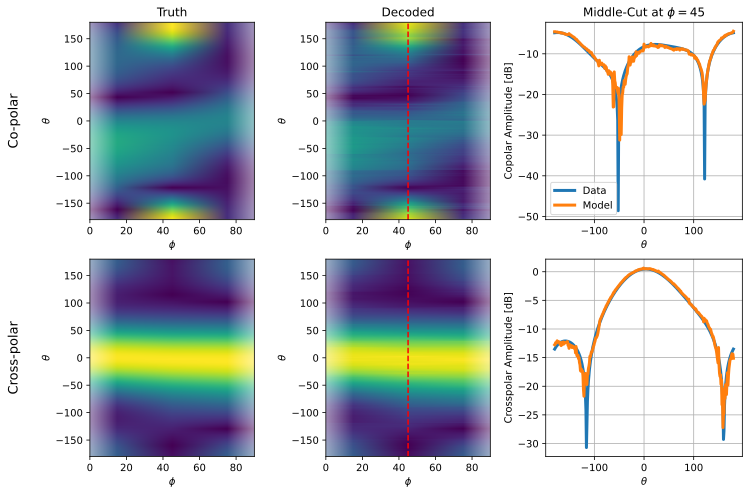

In [251]:
def plotEncodingVerificaiton(model, train_field):
    plt.figure(figsize = (15,10))
    plt.subplot(231)
    plt.imshow(torch.abs(train_field[0,:,:,1:2]),aspect = 1/100)
    plt.subplot(232)
    plt.imshow(torch.abs(model(train_field.float())[0,:,:,1:2]).detach(),aspect = 1/100) 
    plt.subplot(233)
    plt.plot(10*torch.log10(torch.abs(train_field[0,:,1,1:2])))
    plt.plot(10*torch.log10(torch.abs(model(train_field.float())[0,:,1,1:2])).detach()) 
    plt.subplot(234)
    plt.imshow(torch.abs(train_field[0,:,:,3:4]),aspect = 1/100)
    plt.subplot(235)
    plt.imshow(torch.abs(model(train_field.float())[0,:,:,3:4]).detach(),aspect = 1/100)
    plt.subplot(236)
    plt.plot(10*torch.log10(torch.abs(train_field[0,:,1,3:4])))
    plt.plot(10*torch.log10(torch.abs(model(train_field.float()))[0,:,1,3:4]).detach()) 
    plt.subplot_tool(targetfig=fig)
    
def plotEncodingVerificaiton2(model, train_field):

    EXTENT = [0,90,-180,180]
    ASPECT = 0.3
    LINEWIDTH = 3
    X_TEXT_DISPLACEMENT = -45
    thetas = np.linspace(-180,180,361)
    def setImgAxis(ax):
        ax.set_xlabel(r'$ \phi $')
        ax.set_ylabel(r'$ \theta $')
        ax.set_aspect(ASPECT) 

    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axs[0,0].imshow(torch.abs(train_field[0,:,:,1:2]),aspect = 1/100, interpolation = 'none',extent=EXTENT)
    axs[0,0].set_title('Truth')
    axs[0,0].text(X_TEXT_DISPLACEMENT,0,'Co-polar',rotation = 'vertical',fontsize = 13, va = 'center')
    setImgAxis(axs[0,0])

    axs[0,1].imshow(torch.abs(model(train_field.float())[0,:,:,1:2]).detach(), interpolation = 'none',extent=EXTENT)
    axs[0,1].set_title('Decoded')
    axs[0,1].axvline(x = 45, color = 'r', linestyle = '--')
    setImgAxis(axs[0,1])

    axs[0,2].plot(thetas,10*torch.log10(torch.abs(train_field[0,:,1,1:2])),label = 'Data',linewidth = LINEWIDTH)
    axs[0,2].plot(thetas,10*torch.log10(torch.abs(model(train_field.float())[0,:,1,1:2])).detach(),label = 'Model',linewidth = LINEWIDTH) 
    axs[0,2].grid()
    axs[0,2].set_title('Middle-Cut at $\phi = 45$')
    axs[0,2].set_xlabel(r'$\theta$')
    axs[0,2].legend()
    axs[0,2].set_ylabel('Copolar Amplitude [dB]')

    axs[1,0].imshow(torch.abs(train_field[0,:,:,3:4]),aspect = 1/100, interpolation = 'none',extent=EXTENT)
    axs[1,0].text(X_TEXT_DISPLACEMENT,0,'Cross-polar',rotation = 'vertical',fontsize = 13, va = 'center')
    setImgAxis(axs[1,0]) 
    

    axs[1,1].imshow(torch.abs(model(train_field.float())[0,:,:,3:4]).detach(),aspect = 1/100, interpolation = 'none',extent=EXTENT) 
    setImgAxis(axs[1,1])
    axs[1,1].axvline(x = 45, color = 'r', linestyle = '--')

    axs[1,2].plot(thetas,10*torch.log10(torch.abs(train_field[0,:,1,3:4])),linewidth = LINEWIDTH)
    axs[1,2].plot(thetas,10*torch.log10(torch.abs(model(train_field.float())[0,:,1,3:4])).detach(),linewidth = LINEWIDTH) 
    axs[1,2].set_xlabel(r'$\theta$')
    axs[1,2].grid()
    axs[1,2].set_ylabel('Crosspolar Amplitude [dB]')
    

def plotLatentSpace(model,train_loader,test_loader):

    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title('Latent Space Representation of Training Data')
    plt.xlabel("$\chi_1$")
    plt.xlabel("$\chi_2$")
    plt.grid()
    for __,fields in train_loader:

        x,y = model.encode(fields.float()).detach().numpy()
        plt.scatter(x,y)

    plt.subplot(122)
    plt.title('Latent Space Representation of Test Data')
    plt.xlabel("$\chi_1$")
    plt.xlabel("$\chi_2$")
    plt.grid()
    for __,fields in test_loader:

        x,y = model.encode(fields.float()).detach().numpy()
        plt.scatter(x,y)
    

_,TRAIN_FIELDS = next(iter(train_loader))
_,TEST_FIELDS = next(iter(train_loader))


plotEncodingVerificaiton2(model,train_field=TEST_FIELDS)
    
#plotLatentSpace(model,train_loader=train_loader,test_loader=test_loader)


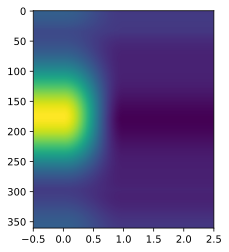

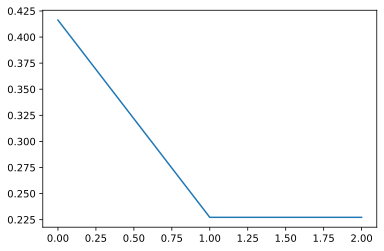

In [203]:
import scipy.fft

fft = scipy.fft.fft(torch.abs(TRAIN_FIELDS[0,:,:,1:2]).numpy(),axis=2)
fft = scipy.fft.fft(fft,axis=1)
plt.figure()
plt.imshow(np.abs(fft[:,:,0]),aspect = 1/100)
plt.figure()
plt.plot(np.abs(fft[0,:,0]))
